<a href="https://colab.research.google.com/github/neuranna/labels-and-categories/blob/master/Labels_%26_Categories_Results.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%bash
!(stat -t /usr/local/lib/*/dist-packages/google/colab > /dev/null 2>&1) && exit 
rm -rf labels-and-categories/
git clone https://github.com/neuranna/labels-and-categories.git

Cloning into 'labels-and-categories'...


In [2]:
!pip install arviz
!pip install pymc3 --upgrade

     |████████████████████████████████| 1.5MB 3.4MB/s eta 0:00:01
     |████████████████████████████████| 6.4MB 14.1MB/s eta 0:00:01
     |████████████████████████████████| 675kB 24.2MB/s eta 0:00:01
     |████████████████████████████████| 296kB 11.2MB/s eta 0:00:01
     |████████████████████████████████| 911kB 2.5MB/s eta 0:00:01     |██████████▌                     | 296kB 2.5MB/s eta 0:00:01
     |████████████████████████████████| 2.8MB 20.2MB/s eta 0:00:01
  Created wheel for theano: filename=Theano-1.0.4-cp37-none-any.whl size=2667178 sha256=b4f3cbd1b07e5544b97e3825b9515f48251ae65ab9acd41a1f686c1dcc2b83ac
  Stored in directory: /Users/anna/Library/Caches/pip/wheels/88/fb/be/483910ff7e9f703f30a10605ad7605f3316493875c86637014
Successfully built theano


In [3]:
import pymc3 as pm
import numpy as np
from scipy import stats
import math
import theano
import theano.tensor as tt
import pickle
import pandas as pd
import matplotlib.pyplot as plt

# Load modeling results

In [4]:
filename = 'labels-and-categories/modelfiles/results_dim1bias1_dim2bias10_corrparam10'
with open(filename, 'rb') as f:
  results_wrong_bias = pickle.load(f)

filename = 'labels-and-categories/modelfiles/results_dim1bias10_dim2bias1_corrparam10'
with open(filename, 'rb') as f:
  results_right_bias = pickle.load(f)

filename = 'labels-and-categories/modelfiles/results_dim1bias10_dim2bias10_corrparam10'
with open(filename, 'rb') as f:
  results_neutral_bias = pickle.load(f)

# Plot results

### Experimental data

Estimated from figures.

In [5]:
# Lupyan data
labels_means_lup = [0.7241, 0.8130, 0.8609, 0.8795, 0.9133, 0.9002, 0.9118, 0.9292, 0.9325]
labels_se_lup = [0.0234, 0.0234, 0.0199, 0.0234, 0.0152, 0.0164, 0.0164, 0.0164, 0.01523]

nolabels_means_lup = [0.6175, 0.6935, 0.7578, 0.7623, 0.8195, 0.8416, 0.9094, 0.8905, 0.9021]
nolabels_se_lup = [0.028, 0.0398, 0.0363, 0.0421, 0.0281, 0.0292, 0.0187, 0.0210, 0.0234]

In [6]:
# Brojde data
values_mean_br = [0.806, 0.739, 0.775, 0.861]
values_se_br = [0.03, 0.033, 0.033, 0.034]

### Model results

In [7]:
def calculate_participant_responses(results):
  N_participants = 75
  N_exemplars = 8    # per category
  means, se = [], []
  for trace in results['traces_pred']:
    df = pm.summary(trace, var_names=['category_posterior'])
    # variance is the sum of item variance
    se.append(np.sqrt(np.sum(df['sd']**2))/N_participants)
    # accuracy is the avg of item accuracy
    df_cat1, df_cat2 = df[0:N_exemplars], df[N_exemplars:]
    means.append(np.mean([np.mean(1-df_cat1['mean']), np.mean(df_cat2['mean'])]))
  return means, se

In [8]:
means_right_bias, se_right_bias = calculate_participant_responses(results_right_bias)
means_neutral_bias, se_neutral_bias = calculate_participant_responses(results_neutral_bias)
means_wrong_bias, se_wrong_bias = calculate_participant_responses(results_wrong_bias)

In [9]:
N_blocks_max = 4
N_participants = 75
grandmean_right_bias = np.mean(means_right_bias[:N_blocks_max])
grandmean_neutral_bias = np.mean(means_neutral_bias[:N_blocks_max])
grandmean_wrong_bias = np.mean(means_wrong_bias[:N_blocks_max])

grandse_right_bias = np.sqrt(np.sum((np.array(se_right_bias[:N_blocks_max])*N_participants)**2))/N_participants
grandse_neutral_bias = np.sqrt(np.sum((np.array(se_neutral_bias[:N_blocks_max])*N_participants)**2))/N_participants
grandse_wrong_bias = np.sqrt(np.sum((np.array(se_wrong_bias[:N_blocks_max])*N_participants)**2))/N_participants

grandmeans = [grandmean_right_bias, grandmean_neutral_bias, grandmean_wrong_bias, grandmean_neutral_bias]
grandse = [grandse_right_bias, grandse_neutral_bias, grandse_wrong_bias, grandse_neutral_bias]

### Make the main results figure

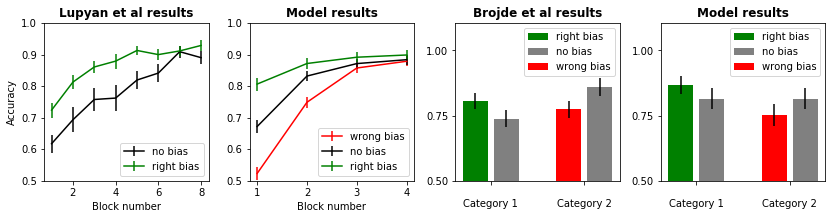

In [27]:
fig = plt.figure(figsize=(14,3))

# Lupyan results
plt.subplot(1,4,1)
N_blocks_max = 8
plt.errorbar(range(1,N_blocks_max+1), nolabels_means_lup[:N_blocks_max], nolabels_se_lup[:N_blocks_max], color='k', label='no bias')
plt.errorbar(range(1,N_blocks_max+1), labels_means_lup[:N_blocks_max], labels_se_lup[:N_blocks_max], color='g', label='right bias')
plt.ylim(0.5,1)
plt.xlabel('Block number')
plt.ylabel('Accuracy')
plt.title('Lupyan et al results', fontweight='bold')
plt.legend(loc='lower right')

# Modeling results - by block
plt.subplot(1,4,2)
N_blocks_max = 4
plt.errorbar(range(1,N_blocks_max+1), means_wrong_bias[:N_blocks_max], se_right_bias[:N_blocks_max], color='r', label='wrong bias')
plt.errorbar(range(1,N_blocks_max+1), means_neutral_bias[:N_blocks_max], se_right_bias[:N_blocks_max], color='k', label='no bias')
plt.errorbar(range(1,N_blocks_max+1), means_right_bias[:N_blocks_max], se_right_bias[:N_blocks_max], color='g', label='right bias')
plt.legend()
plt.ylim(0.5,1)
plt.xlabel('Block number')
plt.title('Model results', fontweight='bold')

# Brojde results
plt.subplot(1,4,3)
plt.bar([1], [values_mean_br[0]], color='g', label='right bias')
plt.bar([2,5], [values_mean_br[1], values_mean_br[3]], color='gray', label='no bias')
plt.bar([4], [values_mean_br[2]], color='r', label='wrong bias')
plt.errorbar(x=[1,2,4,5], y=values_mean_br, yerr=values_se_br, fmt='none', color='k')
plt.ylim(0.5,1.105)
plt.yticks([0.5,0.75,1])
ax = plt.gca()
ax.set_xticks([1.5,4.5])
ax.set_xticklabels(['\nCategory 1', '\nCategory 2'])
plt.title('Brojde et al results', fontweight='bold')
plt.legend()

# Modeling results - avg
plt.subplot(1,4,4)
plt.bar([1], [grandmean_right_bias], color='g', label='right bias')
plt.bar([2,5], [grandmean_neutral_bias, grandmean_neutral_bias], color='gray', label='no bias')
plt.bar([4], [grandmean_wrong_bias], color='r', label='wrong bias')
plt.errorbar(x=[1,2,4,5], y=grandmeans, yerr=grandse, fmt='none', color='k')
plt.ylim(0.5,1.105)
plt.yticks([0.5,0.75,1])
ax = plt.gca()
ax.set_xticks([1.5,4.5])
ax.set_xticklabels(['\nCategory 1', '\nCategory 2'])
plt.title('Model results', fontweight='bold')
plt.legend()

plt.subplots_adjust(wspace=0.25)
plt.gcf().subplots_adjust(bottom=0.15)
plt.savefig("figures/results_main.pdf")

### Compare with results where correlation param = 1

In [11]:
filename = 'labels-and-categories/modelfiles/results_dim1bias1_dim2bias10_corrparam1'
with open(filename, 'rb') as f:
  results_wrong_bias_s1 = pickle.load(f)

filename = 'labels-and-categories/modelfiles/results_dim1bias10_dim2bias1_corrparam1'
with open(filename, 'rb') as f:
  results_right_bias_s1 = pickle.load(f)

filename = 'labels-and-categories/modelfiles/results_dim1bias10_dim2bias10_corrparam1'
with open(filename, 'rb') as f:
  results_neutral_bias_s1 = pickle.load(f)

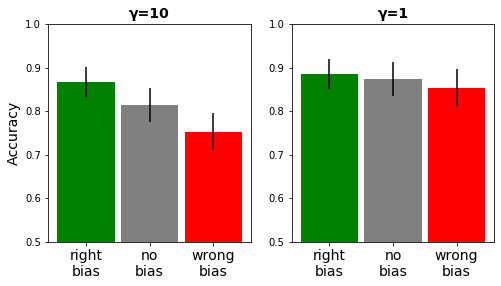

In [12]:
# calculate the means
means_right_bias_s1, se_right_bias_s1 = calculate_participant_responses(results_right_bias_s1)
means_neutral_bias_s1, se_neutral_bias_s1 = calculate_participant_responses(results_neutral_bias_s1)
means_wrong_bias_s1, se_wrong_bias_s1 = calculate_participant_responses(results_wrong_bias_s1)

grandmean_right_bias_s1 = np.mean(means_right_bias_s1[:N_blocks_max])
grandmean_neutral_bias_s1 = np.mean(means_neutral_bias_s1[:N_blocks_max])
grandmean_wrong_bias_s1 = np.mean(means_wrong_bias_s1[:N_blocks_max])

grandse_right_bias_s1 = np.sqrt(np.sum((np.array(se_right_bias[:N_blocks_max])*N_participants)**2))/N_participants
grandse_neutral_bias_s1 = np.sqrt(np.sum((np.array(se_neutral_bias[:N_blocks_max])*N_participants)**2))/N_participants
grandse_wrong_bias_s1 = np.sqrt(np.sum((np.array(se_wrong_bias[:N_blocks_max])*N_participants)**2))/N_participants

grandmeans_s10 = [grandmean_right_bias, grandmean_neutral_bias, grandmean_wrong_bias]
grandse_s10 = [grandse_right_bias, grandse_neutral_bias, grandse_wrong_bias]
grandmeans_s1 = [grandmean_right_bias_s1, grandmean_neutral_bias_s1, grandmean_wrong_bias_s1]
grandse_s1 = [grandse_right_bias_s1, grandse_neutral_bias_s1, grandse_wrong_bias_s1]

# plot
fig = plt.figure(figsize=(8,4))

plt.subplot(1,2,1)
plt.bar([1,2,3], grandmeans_s10, color=['green','gray','red'], width=0.9)
plt.errorbar(x=[1,2,3], y=grandmeans_s10, yerr=grandse_s10, fmt='none', color='k')
plt.ylim(0.5,1)
plt.xticks(range(1,4), ['right\nbias', 'no\nbias', 'wrong\nbias'], fontsize=14)
plt.title('γ=10', fontweight='bold', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)

plt.subplot(1,2,2)
plt.bar([1,2,3], grandmeans_s1, color=['green','gray','red'], width=0.9)
plt.errorbar(x=[1,2,3], y=grandmeans_s1, yerr=grandse_s1, fmt='none', color='k')
plt.ylim(0.5,1)
plt.xticks(range(1,4), ['right\nbias', 'no\nbias', 'wrong\nbias'], fontsize=14)
plt.title('γ=1', fontweight='bold', fontsize=14)
plt.savefig("figures/results_gamma.pdf")

### Simulate participant responses to run stats

In [13]:
def generate_results_table(traces_pred, condition_name):
  N_participants = 75
  N_items = 8    # per category
  N_blocks = 4
  accuracy_df = pd.DataFrame()
  for b in range(N_blocks):
    df = pm.summary(traces_pred[b], var_names=['category_posterior'])
    block_df = pd.DataFrame() 
    predicted_labels, item_ids = [], []
    for i in range(N_items*2):
      for p in range(N_participants):
        predicted_labels.append(np.random.binomial(n=1, p=df['mean'][i]))
        item_ids.append(i)
    block_df['predicted labels'] = np.array(predicted_labels)
    block_df['true labels'] = np.hstack([np.zeros(N_items*N_participants), np.ones(N_items*N_participants)])
    block_df['accuracy'] = 1-np.abs(block_df['predicted labels']-block_df['true labels'])
    block_df['block'] = b+1
    block_df['item'] = item_ids
    accuracy_df = accuracy_df.append(block_df)
  accuracy_df['condition'] = condition_name
  return accuracy_df

In [14]:
df_total = pd.DataFrame()
df_total = df_total.append(generate_results_table(results_wrong_bias['traces_pred'], 'wrong bias'))
df_total = df_total.append(generate_results_table(results_neutral_bias['traces_pred'], 'neutral bias'))
df_total = df_total.append(generate_results_table(results_right_bias['traces_pred'], 'right bias'))
df_total.to_csv('labels-and-categories/tables/participant simulation corrparam10.csv', index=False)

In [15]:
df_total = pd.DataFrame()
df_total = df_total.append(generate_results_table(results_wrong_bias_s1['traces_pred'], 'wrong bias'))
df_total = df_total.append(generate_results_table(results_neutral_bias_s1['traces_pred'], 'neutral bias'))
df_total = df_total.append(generate_results_table(results_right_bias_s1['traces_pred'], 'right bias'))
df_total.to_csv('labels-and-categories/tables/participant simulation corrparam1.csv', index=False)